In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/pickles1/emotion_tokenizer_1.p
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.50d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.100d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.200d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.300d.txt
/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin
/kaggle/input/contextmodels/sentiment_model.h5
/kaggle/input/contextmodels/emotion_model_2_1.h5
/kaggle/input/contextmodels/emotion_model_1_1.h5
/kaggle/input/sarcasmclean/test.csv
/kaggle/input/sarcasmclean/train.csv
/kaggle/input/sarcasmclean/cv.csv
/kaggle/input/pickles/sentiment_tokenizer.p
/kaggle/input/pickles/emotion_tokenizer.p


In [29]:
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from keras.regularizers import l2
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import optimizers

import keras
from keras.utils import plot_model
import tensorflow_hub as hub
import tensorflow as tf

import pydotplus as pyd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [24]:
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)

def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [4]:
train = pd.read_csv('/kaggle/input/sarcasmclean/train.csv')
cv = pd.read_csv('/kaggle/input/sarcasmclean/cv.csv')
test = pd.read_csv('/kaggle/input/sarcasmclean/test.csv')

train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,1,but they will have all those reviews,RoguishPoppet,ProductTesting,0,-1,-1,2016-11,2016-11-01 02:04:59,"The dumb thing is, they are risking their sell..."
1,1,wow it is totally unreasonable to assume that ...,pb2crazy,politics,2,-1,-1,2016-11,2016-11-01 02:42:11,Clinton campaign accuses FBI of 'blatant doubl...
2,1,ho ho ho but melania said that there is no way...,pb2crazy,politics,8,-1,-1,2016-10,2016-10-18 16:20:53,Anyone else think that it was interesting the ...
3,1,i can not wait until potus starts a twitter wa...,kitduncan,politics,3,-1,-1,2016-11,2016-11-01 03:22:33,Here's what happens when Obama gives up his Tw...
4,1,gotta love the teachers who give exams on the ...,DEP61,CFBOffTopic,3,-1,-1,2016-11,2016-11-01 03:30:11,Monday night Drinking thread Brought to You by...


In [5]:
train['label'].value_counts()

0    399994
1    399978
Name: label, dtype: int64

In [6]:
test['label'].value_counts()

0    49999
1    49984
Name: label, dtype: int64

In [7]:
train['comment'] = train['comment'].astype(str)
cv['comment'] = cv['comment'].astype(str)
test['comment'] = test['comment'].astype(str)

train['author'] = train['author'].astype(str)
cv['author'] = cv['author'].astype(str)
test['author'] = test['author'].astype(str)

In [8]:
t = Tokenizer()
t.fit_on_texts(train['comment'].values)
vocab_size = len(t.word_index) + 1
print(vocab_size)

138775


In [9]:
encoded_comments_train = t.texts_to_sequences(train['comment'])
encoded_comments_cv = t.texts_to_sequences(cv['comment'])
encoded_comments_test = t.texts_to_sequences(test['comment'])

In [10]:
lengths = []

for doc in encoded_comments_train:
    lengths.append(len(doc))

In [11]:
np.percentile(lengths, 99.9)

66.0

In [12]:
max_length = 70
padded_comments_train = pad_sequences(encoded_comments_train, maxlen=max_length, padding='post')
padded_comments_cv = pad_sequences(encoded_comments_cv, maxlen=max_length, padding='post')
padded_comments_test = pad_sequences(encoded_comments_test, maxlen=max_length, padding='post')

In [13]:
y_train = train['label'].values
y_cv = cv['label'].values
y_test = test['label'].values

y_train = to_categorical(y_train, num_classes=2)
y_cv = to_categorical(y_cv, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [14]:
w2v_model = KeyedVectors.load_word2vec_format('/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin', binary=True)

In [15]:
# create a weight matrix for words in training docs
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector
        
embedding_matrix_w2v.shape

(138775, 300)

In [16]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model 1: Baseline

In [31]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 70)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 70, 300)           41632500  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 67, 50)            60050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 33, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31, 100)           15100     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 100)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1500)              0   

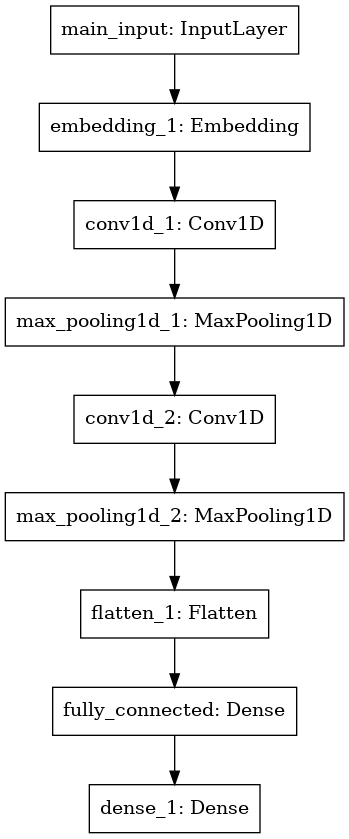

In [32]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model_01.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_01')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_01.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h1 = model_01.fit(padded_comments_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(padded_comments_cv, y_cv))

In [ ]:
score_1 = model_01.evaluate(padded_comments_test, y_test)
score_1

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_comments_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h1.history['f1_m'][1:])
plt.plot(h1.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model Los')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 2: Baseline + Sentiments

In [ ]:
sentiment_model = load_model('/kaggle/input/contextmodels/sentiment_model.h5', custom_objects={'f1_m': f1_m})
sentiment_tokenizer = openfromfile('/kaggle/input/pickles/sentiment_tokenizer')

In [ ]:
encoded_comments_train_1 = sentiment_tokenizer.texts_to_sequences(train['comment'])
encoded_comments_cv_1 = sentiment_tokenizer.texts_to_sequences(cv['comment'])
encoded_comments_test_1 = sentiment_tokenizer.texts_to_sequences(test['comment'])

In [ ]:
padded_comments_train_1 = pad_sequences(encoded_comments_train_1, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv_1, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test_1, maxlen=140, padding='post')

In [ ]:
output_layer_sentiment = 'fully_connected'
intermediate_layer_model_1 = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train = intermediate_layer_model_1.predict(padded_comments_train_1)
intermediate_output_cv = intermediate_layer_model_1.predict(padded_comments_cv_1)
intermediate_output_test = intermediate_layer_model_1.predict(padded_comments_test_1)

In [ ]:
intermediate_output_train.shape

In [33]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_sent = Input(shape=(100,), name='sentiment_input')
concat = concatenate([dense, input_sent])

out = Dense(2, activation='softmax')(concat)

model_02 = Model(inputs=[input_data, input_sent], outputs=[out])

print(model_02.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 67, 50)       60050       embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 33, 50)       0           conv1d_3[0][0]                   
____________________________________________________________________________________________

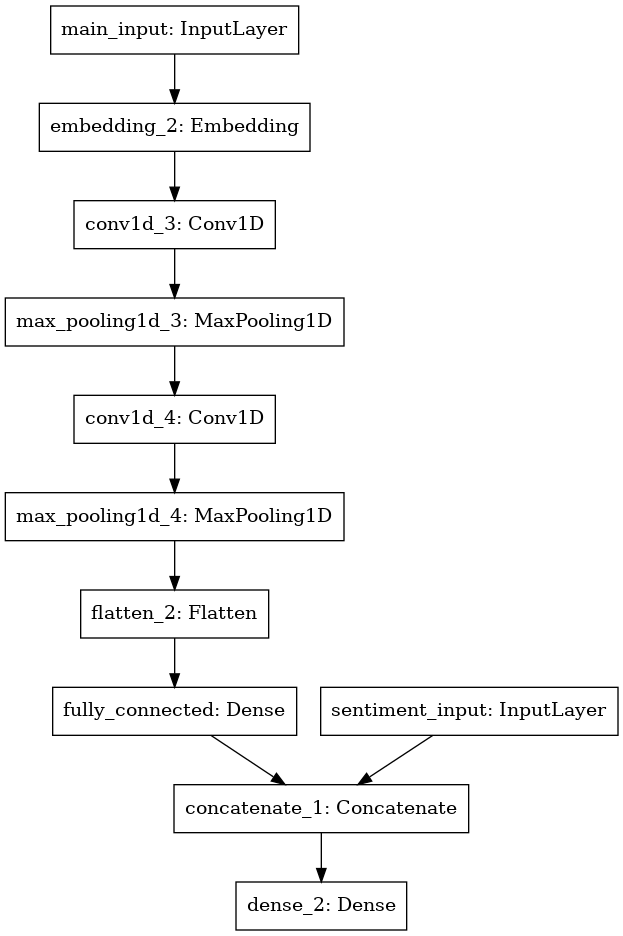

In [34]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_02, to_file='model_02.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_02')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_02.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 10,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_02.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv)]
X_test = [padded_comments_test, np.array(intermediate_output_test)]

h2 = model_02.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_2 = model_02.evaluate(X_test, y_test)
score_2

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_02.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h2.history['f1_m'][1:])
plt.plot(h2.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h2.history['loss'][1:])
plt.plot(h2.history['val_loss'][1:])
plt.title('Model Los')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 3: Baseline + Emotion_1

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_1_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles/emotion_tokenizer')

In [ ]:
encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['comment'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['comment'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['comment'])

In [ ]:
padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

In [ ]:
output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
intermediate_output_train.shape

In [35]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_emo])

out = Dense(2, activation='softmax')(concat)

model_03 = Model(inputs=[input_data, input_emo], outputs=[out])

print(model_03.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 67, 50)       60050       embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 33, 50)       0           conv1d_5[0][0]                   
____________________________________________________________________________________________

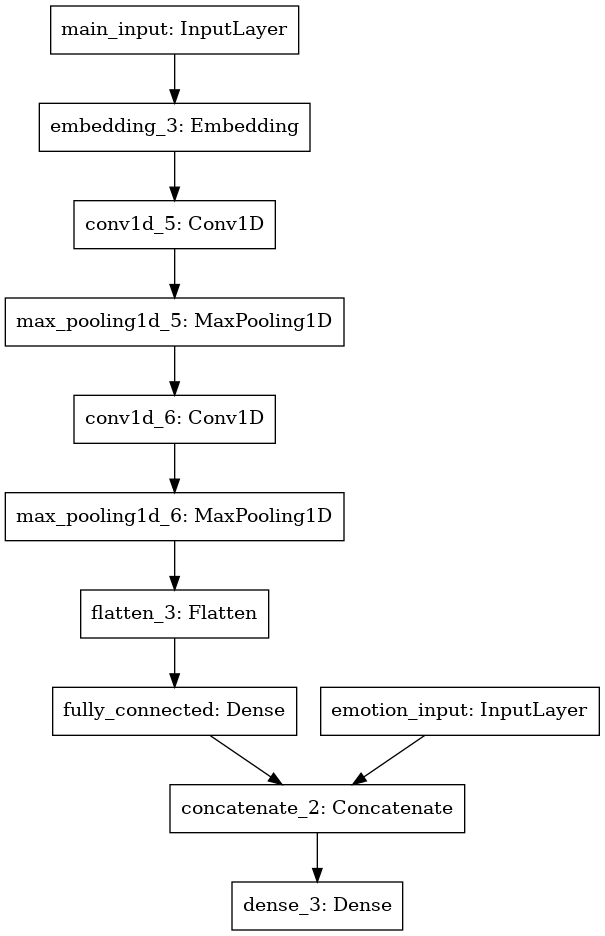

In [36]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_03, to_file='model_03.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_03')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_03.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_03.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv)]
X_test = [padded_comments_test, np.array(intermediate_output_test)]

h3 = model_03.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_3 = model_03.evaluate(X_test, y_test)
score_3

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_03.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h3.history['f1_m'][1:])
plt.plot(h3.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h3.history['loss'][1:])
plt.plot(h3.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 4: Baseline + Emotion_2

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_2_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles1/emotion_tokenizer_1')

In [ ]:
encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['comment'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['comment'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['comment'])

In [ ]:
padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=300, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=300, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=300, padding='post')

In [ ]:
output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
intermediate_output_train.shape

In [37]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_emo])

out = Dense(2, activation='softmax')(concat)

model_04 = Model(inputs=[input_data, input_emo], outputs=[out])

print(model_04.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 67, 50)       60050       embedding_4[0][0]                
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 33, 50)       0           conv1d_7[0][0]                   
____________________________________________________________________________________________

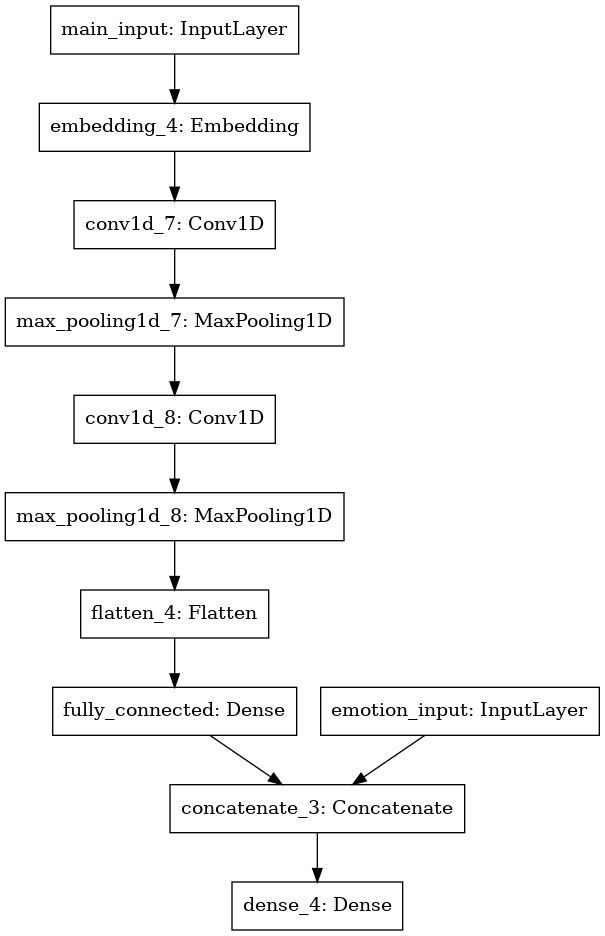

In [38]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_04, to_file='model_04.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_04')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_04.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_04.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv)]
X_test = [padded_comments_test, np.array(intermediate_output_test)]

h4 = model_04.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_4 = model_04.evaluate(X_test, y_test)
score_4

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_04.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h4.history['f1_m'][1:])
plt.plot(h4.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h4.history['loss'][1:])
plt.plot(h4.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 5: Baseline + Sentiment + Emotion_1

In [ ]:
sentiment_model = load_model('/kaggle/input/contextmodels/sentiment_model.h5', custom_objects={'f1_m': f1_m})
sentiment_tokenizer = openfromfile('/kaggle/input/pickles/sentiment_tokenizer')

encoded_comments_train = sentiment_tokenizer.texts_to_sequences(train['comment'])
encoded_comments_cv = sentiment_tokenizer.texts_to_sequences(cv['comment'])
encoded_comments_test = sentiment_tokenizer.texts_to_sequences(test['comment'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

output_layer_sentiment = 'fully_connected'
intermediate_layer_model = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train_1 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_1 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_1 = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_1_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles/emotion_tokenizer')

encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['comment'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['comment'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['comment'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train_2 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_2 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_2 = intermediate_layer_model.predict(padded_comments_test_1)

In [39]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_sent = Input(shape=(100,), name='sentimet_input')
input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_sent, input_emo])

out = Dense(2, activation='softmax')(concat)

model_05 = Model(inputs=[input_data, input_sent, input_emo], outputs=[out])

print(model_05.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 67, 50)       60050       embedding_5[0][0]                
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 33, 50)       0           conv1d_9[0][0]                   
____________________________________________________________________________________________

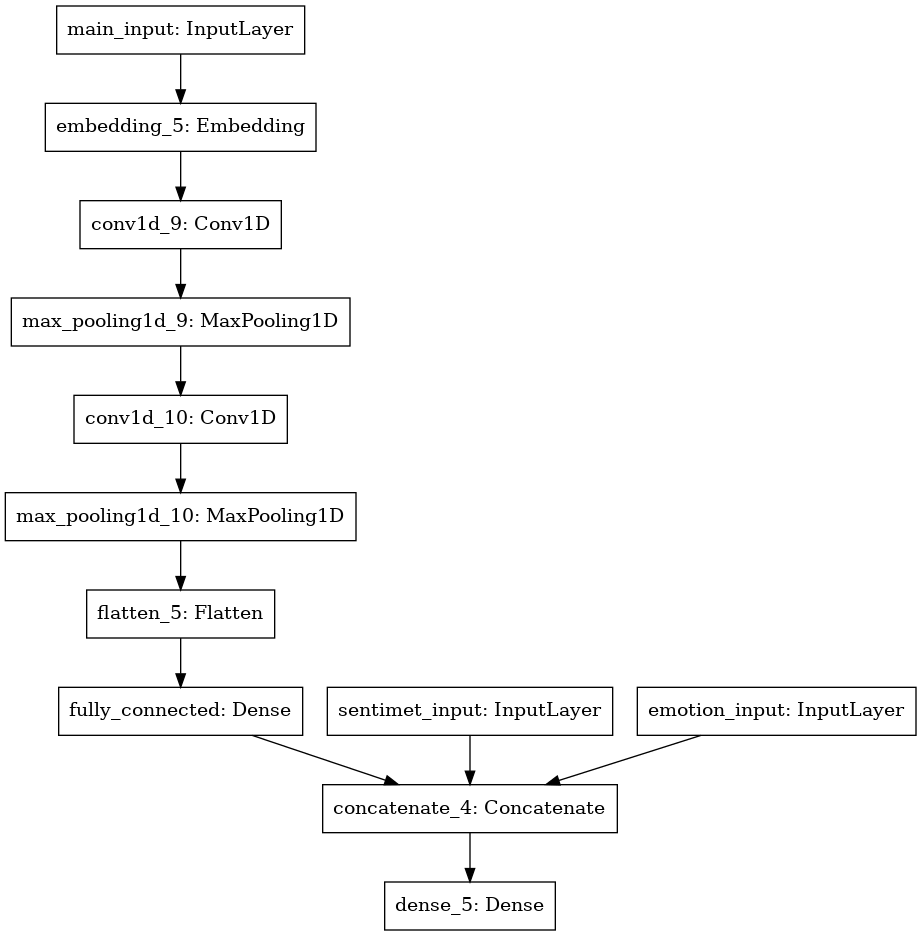

In [40]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_05, to_file='model_05.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_05')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_05.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_05.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train_1), np.array(intermediate_output_train_2)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv_1), np.array(intermediate_output_cv_2)]
X_test = [padded_comments_test, np.array(intermediate_output_test_1), np.array(intermediate_output_test_2)]

h5 = model_05.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_5 = model_05.evaluate(X_test, y_test)
score_5

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_05.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h5.history['f1_m'][1:])
plt.plot(h5.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h5.history['loss'][1:])
plt.plot(h5.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 6: Baseline + Sentiment + Emotion_2

In [ ]:
del w2v_model

In [ ]:
sentiment_model = load_model('/kaggle/input/contextmodels/sentiment_model.h5', custom_objects={'f1_m': f1_m})
sentiment_tokenizer = openfromfile('/kaggle/input/pickles/sentiment_tokenizer')

encoded_comments_train = sentiment_tokenizer.texts_to_sequences(train['comment'])
encoded_comments_cv = sentiment_tokenizer.texts_to_sequences(cv['comment'])
encoded_comments_test = sentiment_tokenizer.texts_to_sequences(test['comment'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

output_layer_sentiment = 'fully_connected'
intermediate_layer_model = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train_1 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_1 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_1 = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_2_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles1/emotion_tokenizer_1')

encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['comment'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['comment'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['comment'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=300, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=300, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=300, padding='post')

output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train_2 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_2 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_2 = intermediate_layer_model.predict(padded_comments_test_1)

In [41]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_sent = Input(shape=(100,), name='sentimet_input')
input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_sent, input_emo])

out = Dense(2, activation='softmax')(concat)

model_06 = Model(inputs=[input_data, input_sent, input_emo], outputs=[out])

print(model_06.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 67, 50)       60050       embedding_6[0][0]                
__________________________________________________________________________________________________
max_pooling1d_11 (MaxPooling1D) (None, 33, 50)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [ ]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_06, to_file='model_06.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_06')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_06.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_06.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train_1), np.array(intermediate_output_train_2)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv_1), np.array(intermediate_output_cv_2)]
X_test = [padded_comments_test, np.array(intermediate_output_test_1), np.array(intermediate_output_test_2)]

h6 = model_06.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_6 = model_06.evaluate(X_test, y_test)
score_6

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_06.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h6.history['f1_m'][1:])
plt.plot(h6.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h6.history['loss'][1:])
plt.plot(h6.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Conclusions

In [6]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model', 'F1-Score', '% of sarcastic comments correcly classified']
x.add_row(['1', '0.7234', '73.58'])
x.add_row(['2', '0.7179', '71.78'])
x.add_row(['3', '0.7242', '71.75'])
x.add_row(['4', '0.7235', '72.07'])
x.add_row(['5', '0.7222', '70.71'])
x.add_row(['6', '0.7215', '72.10'])

In [7]:
print(x)

+-------+----------+---------------------------------------------+
| Model | F1-Score | % of sarcastic comments correcly classified |
+-------+----------+---------------------------------------------+
|   1   |  0.7234  |                    73.58                    |
|   2   |  0.7179  |                    71.78                    |
|   3   |  0.7242  |                    71.75                    |
|   4   |  0.7235  |                    72.07                    |
|   5   |  0.7222  |                    70.71                    |
|   6   |  0.7215  |                    72.10                    |
+-------+----------+---------------------------------------------+
